## Logical modeling of neuroectoderm specification in fruit flies

Egfr signaling is one of the signaling networks regulating fruit fly neuroectoderm development. Given the complexity of signaling networks as well as the amount of information to be integrated, a logical model of Egfr signaling will provide a better understanding of how developmental signals combine to control cellular states.


This project implements CoLoMoTo Interactive Notebook to provide a reprodicible and executable analyses. The workflow used as follows:

(1) the importation of a GINsim model and its display, (2) its format conversion using the Java library BioLQM, (3) the formal prediction of mutations using the OCaml software Pint, (4) the model checking using the C++ software NuSMV, (5) quantitative stochastic simulations using the C++ software MaBoSS, and (6) the visualisation of results using the Python library matplotlib. 

### Visualization of Egfr pathway with GINsim

In [1]:
# Set up working environment for CoLoMoTo
%matplotlib inline
import numpy as np
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import DataFrame
import seaborn as sns
import re
import pprint
from collections import Counter
#import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Tools necessary to run and perturb the model
import ginsim 
import biolqm
import pypint
import maboss

# Tools necessary to format and plot results of simulations
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
import pandas as pd # for the visualization of lists of states


This notebook has been executed using the docker image `colomoto/colomoto-docker:2021-02-01`

## Import model from github repository

Logical models can be loaded from my github repository at https://github.com/ozlembahar/DevelopmentalSignaling/blob/master/Ginsim.

In [2]:
# Loading model in the variable lrg_ppt using pint module and show summary statitics
lrg_ppt = pypint.load("Hh-Wg-Egfr-one-level-reduced.zginml")
info_lrg = lrg_ppt.summary()
pd.DataFrame([['nb_states',info_lrg['nb_states']],['nb_automata',info_lrg['nb_automata']],['nb_transitions',info_lrg['nb_transitions']]], columns=['Item','Number'])

gs_model = ginsim.load("Hh-Wg-Egfr-one-level-reduced.zginml")
lqm_model = ginsim.to_biolqm(gs_model)
# Display the regulatory graph as specified in the model file
ginsim.show(gs_model)

3 state(s) have been registered: DV, AP, DV-AP

In this regulatory graph, green arrows and red T arrows respectively denote activatory and inhibitory interactions. A set of rules combining the vertices with the Boolean operators NOT, AND, and OR, which must be consistent with the regulatory graph, then allows the computation of enabled transitions for each network state.

## Boolean functions



Boolean functions of the each of the # components summarized in a table.

## Helper functions

Some helper functions and color mapping rules to perform value propagation and visualize the result.

In [3]:
# Transforms a dictionary into a dash-like pattern used for space restrictions.
# If a model has 4 components A, B, C, D in this order,
#  {A:0, D:1} => "0--1"
def dash_pattern(model, dict_vals):
    specific_comps = dict_vals.keys()
    str_pattern = ""
    for comp in model.getComponents():
        if comp.toString() in specific_comps:
            str_pattern += str(dict_vals.get(comp.toString()))
        else :
            str_pattern += "-"
    return(str_pattern)

def restrict_model(model, **dict_vals):
    pattern = dash_pattern(lqm_model, dict_vals)
    return biolqm.restrict(lqm_model, pattern)

def fill_fixed(data, names, functions, mddman):
    all_values = [f for f in functions]
    for comp, func in zip(names, functions):
        if mddman.isleaf(func): data[comp] = func
        else: data[comp] = -1
    

def get_fixed_pattern(all_names, model, as_dict=False):
    # Build a container for the results
    pattern = {key: 100 for key in all_names}
    
    # Model manager and core components
    mddman = model.getMDDManager()
    core_components = [node.getNodeID() for node in model.getComponents()]
    extra_components = [node.getNodeID() for node in model.getExtraComponents()]
    
    # 1/ Non-extra values: if the model was not reduced, core components may also contain fixed values
    fill_fixed(pattern, core_components, model.getLogicalFunctions(), mddman)

    # Special value for input components
    for node in model.getComponents():
        if node.isInput():
            pattern[node.getNodeID()] = -2

    
    # 2/ Extra values : only available after reduction/percolation
    # Functions of each component
    fill_fixed(pattern, extra_components, model.getExtraLogicalFunctions(), mddman)

    if as_dict: return pattern
    return pd.Series(pattern, dtype=np.byte).values.tobytes()

def compare_fixed_pattern(all_names, model1, model2, as_dict=False):
    pattern1 = get_fixed_pattern(all_names, model1, as_dict=True)
    pattern2 = get_fixed_pattern(all_names, model2, as_dict=True)
    
    pattern = {}
    for c in pattern1:
        v1 = pattern1[c]
        v2 = pattern2[c]
        
        if v1 == v2: pattern[c] = v1
        elif v1 < 0: pattern[c] = 10 + v2
        elif v2 < 0: pattern[c] = 20 + v1
        else: pattern[c] = 100

    if as_dict: return pattern
    return pd.Series(pattern, dtype=np.byte).values.tobytes()


def show_fixed_comparison(gs_model, restricted_model1, restricted_model2, styler, save=None):
    name_components = [ n.getId() for n in gs_model.getNodeOrder() ]
    pattern = compare_fixed_pattern(name_components, restricted_model1, restricted_model2)
    styler.setState( pattern )
    return ginsim.show(gs_model, style=styler, save=save)    


def show_fixed(gs_model, restricted_model, styler, save=None):
    name_components = [ n.getId() for n in gs_model.getNodeOrder() ]
    fixed_pattern = get_fixed_pattern(name_components, restricted_model)
    styler.setState(fixed_pattern)
    return ginsim.show(gs_model, style=styler, save=save)


# Define color mapping rules

# Style for a single fixed pattern
styler_fixed = ginsim.lrg_style(gs_model)
styler_fixed.mapState2Color(0, 200, 25, 25)
styler_fixed.mapState2Color(1, 100, 175, 100)
styler_fixed.mapState2Color(2, 100, 225, 100)
styler_fixed.mapState2Color(-1, 255, 255, 255)
styler_fixed.mapState2Color(-2, 175, 175, 175)


# Style for comparing two patterns
styler_comp = ginsim.lrg_style(gs_model)
styler_comp.mapState2Color(-2, 175, 175, 175) # INPUT: gray
styler_comp.mapState2Color(0, 255, 255, 180)  # OFF  in both: light yellow
styler_comp.mapState2Color(1, 255, 180, 120)  # ON   in both: light orange
styler_comp.mapState2Color(2, 255, 180, 120)  # HIGH in both: light orange
styler_comp.mapState2Color(-1, 255, 255, 255) # FREE in both: white
styler_comp.mapState2Color(10, 200, 255, 200) # OFF in the first: light green
styler_comp.mapState2Color(11, 125, 200, 125) # ON  in the first: dark green
styler_comp.mapState2Color(20, 200, 200, 255) # OFF in the second: light green
styler_comp.mapState2Color(21, 125, 125, 200) # ON  in the second: dark green
styler_comp.mapState2Color(100, 255, 180, 180) # Other (different values?): red

## Identification of stable states

Here we compute the complete list of logical stable states (or fixpoints) of the model using the Java library bioLQM and store it in the `fps` variable:

In [13]:
fps = biolqm.fixpoints(lqm_model)
print(len(fps), "fixpoints found.")

39 fixpoints found.


In [14]:
#Display of the list of stable states
tabulate(fps)

,Hh_ex,Wg_ex,Spi,Aos,Ptc,Smo,Pka,Ci_act,Wg,Ci_rep,Fz,En,Hh,Egfr,Rl,Pnt,pGro,Gro,ind,vnd,msh,Neural_ID
0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,1
2,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,1
4,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1
6,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1
1,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,1
3,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,1
5,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1
7,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1
8,0,0,1,0,0,1,0,1,1,0,0,1,1,1,1,1,1,0,0,1,0,1
9,0,0,1,0,0,1,0,1,1,0,0,1,1,1,1,1,1,0,1,0,0,1


In [6]:
#The third fixpoint (`fps[2]`) can then be displayed as follows:
ginsim.show(gs_model, fps[2])

In this graph, the vertices shown in white or blue denote components that are OFF (value 0) or ON (value 1) respectively.

## Identification of trap spaces

A trap space is a subspace of a state space which trajectories cannot leave. Trap spaces provide useful approaximations of attraction basin. Every trap space contains at least one attractor and, therefore, in some cases minimal trap spaces can be good approximations for the attractors. If a trap set is an attractor, its spaces of attraction can be related to its basins of attraction. Attractor reachability can be investigated using trap spaces.

In [7]:
trapspaces = biolqm.trapspaces(lqm_model)
tabulate(trapspaces)

,Hh_ex,Wg_ex,Spi,Aos,Ptc,Smo,Pka,Ci_act,Wg,Ci_rep,Fz,En,Hh,Egfr,Rl,Pnt,pGro,Gro,ind,vnd,msh,Neural_ID
36,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,1
17,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,1
25,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1
28,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1
38,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,1
13,0,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,1
23,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1
26,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1
20,0,0,1,0,0,1,0,1,1,0,0,1,1,1,1,1,1,0,0,1,0,1
11,0,0,1,0,0,1,0,1,1,0,0,1,1,1,1,1,1,0,1,0,0,1


In [8]:
 ginsim.show(gs_model, trapspaces[5])

In [49]:
# Find wild-type stable states

fps_pd = pd.DataFrame(fps)
fps_pd = fps_pd.iloc[:,0:4]
fps_pd['input_list'] = fps_pd['Hh_ex'].astype(str) + fps_pd['Wg_ex'].astype(str) + fps_pd['Spi'].astype(str) + fps_pd['Aos'].astype(str) 
#fps_pd[fps_pd["input_list"] == "Hh_ex-Wg_ex'-Spi-Aos"].index.values
DV_index = fps_pd[fps_pd["input_list"] == "0011"].index.values
AP_index = fps_pd[fps_pd["input_list"] == "1101"].index.values
DV_AP_index = fps_pd[fps_pd["input_list"] == "1110"].index.values

# DV stable state
ginsim.show(gs_model, fps[DV_index[2]]) # 4 stable states in total

In [47]:
# AP stable states, 2 in total
ginsim.show(gs_model, fps[AP_index[1]])

In [53]:
# DV-AP stable states, 2 in total
ginsim.show(gs_model, fps[DV_AP_index[1]])

In [ ]:
# DV-AP stable state_1
ginsim.show(gs_model, fps[DV_AP_index[1]])


## Assessing the probabilities to reach alternative attractors using MaBoSS

MaBoSS (Stoll et al., 2017) is a C++ software enabling the stochastic simulation of Boolean networks by translating them into continuous time Markov processes. Each node activation and inactivation is associated with an up and a down rate, which specify the propensity of the corresponding transitions. From a given state, the simulation integrates all the possible node updates and derives a probability and a duration for each transition. By default, all transitions are assigned the same rate. For a given set of initial conditions, MaBoSS produces time trajectories and estimates probabilities of model states over the whole simulation time. Steady state distributions can thus be approximated, provided that a sufficient number of sufficiently long simulations have been performed.

The aim of this section is to reproduce part of the results obtained by Cohen et al. (2015), which show that a Notch (NICD) gain-of-function together with a p53 loss-of-function prevent reaching a stable apoptotic phenotype.

First, we convert the bioLQM model to MaBoSS:

In [54]:
wt_sim = biolqm.to_maboss(lqm_model)

In [55]:
#maboss.wg_set_istate(wt_sim)
maboss.set_nodes_istate(wt_sim, ["Hh_ex","Spi"], [0.5, 0.5])

In [56]:
#maboss.wg_set_output(wt_sim)
wt_sim.network.set_output(('ind', 'vnd', 'msh', 'En'))

In [57]:
wt_sim.update_parameters(discrete_time=0, use_physrandgen=0,
        seed_pseudorandom=100, sample_count=50000,
        max_time=75, time_tick=0.1, thread_count=4,
        statdist_traj_count=100, statdist_cluster_threshold=0.9)

In [58]:
%time wt_results = wt_sim.run()

CPU times: user 1.86 ms, sys: 5.5 ms, total: 7.36 ms
Wall time: 1.97 s


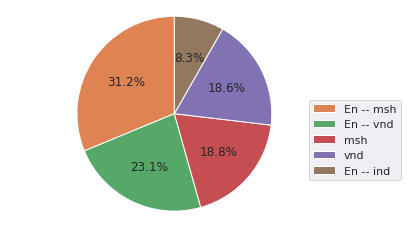

In [59]:
wt_results.plot_piechart()

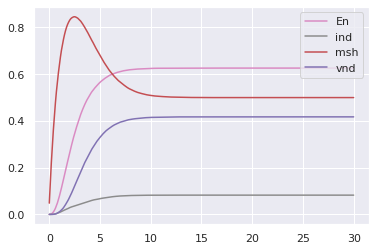

In [60]:
wt_results.plot_node_trajectory(until=30)

In [61]:
mut_sim = wt_sim.copy()
mut_sim.mutate("Hh_ex", "OFF")

In [62]:
%time mut_results = mut_sim.run()

CPU times: user 500 µs, sys: 7.62 ms, total: 8.12 ms
Wall time: 2.04 s


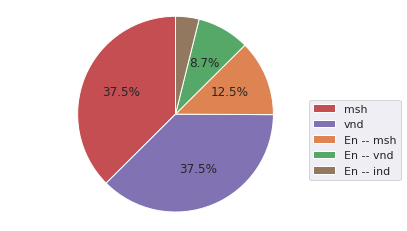

In [63]:
mut_results.plot_piechart()